# Principal component analysis

The intention of this notebook is to perform the PCA analysis on genotype data and generate plots.

## Overview


Steps to generate a PCA include 

- removing related individuals
- pruning variants in linkage disequilibrium (LD)
- perform PCA analysis on genotype of unrelated individuals
- excluding outlier samples in the PCA space for individuals of homogeneous self-reported ancestry. These outliers may suggest poor genotyping quality or distant relatedness.

Pitfalls

1. Some of the PCs may capture LD structure rather than population structure (decrease in power to detect associations in these regions of high LD)
2. When projecting a new study dataset to the PCA space computed from a reference dataset: projected PCs are shrunk toward 0 in the new dataset
3. PC scores may capture outliers that are due to family structure, population structure or other reasons; it might be beneficial to detect and remove these individuals to maximize the population structure captured by PCA (in the case of removing a few outliers) or to restrict analyses to genetically homogeneous samples

## Input

1. Genotype in PLINK format: common variants, LD pruned.
2. Phenotype files in text format and must contain columns named 'FID' and 'IID' for family ID and individual ID. If you do not have a phenotype file you can inpute a PLINK fam file. The phenotype file can additionally contain population information and possibly disease or other labelling information, to label the PCA plots.

The inputs should be splitted into sets of related and unrelated individuals. Additionally you may want to prepare data per population. See "How to run this workflow" section for more details.

## Output

1. PCA models (inside RDS file)
2. PCA scores (inside RDS file)
3. Mahalanobis distances and outliers to remove
4. Various plots

## General workflow

1. Estimate relatedness of the individuals in the sample by PLINK 2 that implements the KING algorithm
2. Select specific SNPs and samples using PLINK (QC maf>1%, geno missing rate (`geno`) 0.1, individual missing rate (`mind`) =0.1 and `hwe`=5e-08), and remove related individuals
3. SNPs thining by doing LD-pruning (window=50, shift=10, r2=0.1 are the defaults)
4. Run PCA using only unrelated individuals for all populations, and examine the resulting plot
5. Project back related individuals, and generate a list of suggested samples to remove based on Mahalanobis distance test statistic per population. Default criteria is 0.997 percentile (two sided) but we recommend checking the output plot before and after removal and rethink about it.

If you have subpopulations in the data, then additional steps should be applied for:

6. Split data into different populations, each population data should have both related vs unrelated individual data-sets
7. For each population, perform QC
8. For each population, re-calculate per population PC's for unrelated individuals
9. For each population, project related samples back to the PC space
10. Remove outliers based on list previously generated


## Method

Here is a quick recap of PCA analysis for those not immediately familiar with the method. PCA is a mathematical method to reduce dimensionality of the data while retaining most of the variation in the dataset. 
This is accomplished by identifying directions or Principal Components (PC's) that account for the maximum variation in the data. 

One common approach to PCA is based on the singular-value decomposition of the the data matrix $X$ (in our case the genotype matrix),
$$X = U D V^T,$$
where $U$ are the left eigenvectors, $D$ is the diagonal matrix of singular values, and $V$ are the right eigenvectors (also called loadings). 

PCA can also be done using the eigen-decomposition of $X X^T$
$$X X^T = U S U^T,$$ where $S=D^2$ is the diagonal matrix of eigenvalues.
$X$ is usually centred (mean-subtracted) or standardised (mean subtracted, then divided by standard deviation) before PCA.

For PCA of SNP genotypes (at least in diploid organisms), the common standardisation is
$$X_{ij}^{\prime} = \frac{X_{ij} - 2p_j}{\sqrt{2 p_j (1 - p_j)}},$$
where $X_{ij}$ is the genotype (minor allele dosage $\{0, 1, 2\}$) for the $i$th individual and the $j$th SNP, and $p_j$ is the minor allele frequency (MAF) for the $j$th SNP. In addition, the eigenvalues are scaled by the number of SNPs $m$ (equivalent to performing the eigen-decomposition of $XX^T/m$).


## How to run this workflow

### Step 1: Estimate kinship in the sample
Aim: identify and output closely related individuals prior to PCA analysis.

```
sos run GWAS_QC.ipynb king \
    --genoFile <all_samples.bed>
```

### Step 2 and 3: Sample selection and QC the genetic data 

1. QC based on MAF, sample and variant missigness and Hardy-Weinberg Equilibrium. You can provide a list of samples to keep, or to remove. For example:
    - Only extract data for one population
    - Only extract data for related individuals
    - Only extract data for unrelated individuals
   In current context we would like to extract data for unrelated individuals and proceed with the rest of the QC steps.
2. LD pruning. Prune SNPs in linkage dissequilibrium to make sure the PCA actually captures population structure and not LD structure (which could reduce the power of detecting genetic associations in these LD-regions).

`king` will split data into unrelated and related individuals. We will QC on unrelated individuals but **extract the same variants from related individuals**. We therefore only run `qc` with a list of variants extracted, and other filtering parameters set to 0.

```
sos run GWAS_QC.ipynb qc \
    --genoFile <unrelated_samples.bed> \
    --maf-filter ... \
    ...
```
```
sos run GWAS_QC.ipynb qc \
    --genoFile <related_samples.bed> \
    --keep-variants <previous_command_output.prune.in> \
    --maf-filter 0 --geno-filter 0 --mind-filter 0 --hwe-filter 0 --r2 0 \
    ...
```

### Step 4: PCA analysis for all samples

```
sos run PCA.ipynb flashpca \
    --genoFile <unrelated_samples.bed>
    --phenoFile <phenotypes.txt>
```

If your phenoFile has a categorical variable with the ethnicity or population you can use `label_col` parameter to define it, so that the plot generated has different colors depending on the population

### Step 5: Projection of related individuals and outlier detection 

```
sos run PCA.ipynb project_samples \
    --pca-model <unrelated_samples.pca.rds> \
    --genoFile <related_samples.bed> \
    --phenoFile <phenotypes.txt>
```

Same as above, if you have an ethnicity variable you can specify it by using `label_col` and here you would also need to add `pop_col` that points to the same variable. This is necessary, otherwise the detect_outliers part of the workflow will error. 


### Step 6: Split data by population

If you are analyzing a homogenous population please jump to Step 10.

For each population, you can still use the GWAS_QC.ipynb and PCA.ipynb workflows, except that at this step you have to work manually on the `--remove-samples` and `--keep-samples` files.

Please do this manually now to create `remove-samples` (of related and not in the current pop) and `keep-samples` (of related and in the current pop) for next steps.

### Step 7: For each population perform QC

Get unrelated individuals

```
sos run GWAS_QC.ipynb qc \
    --genoFile <all_samples.bed> \
    --remove-samples  <king_output.related_id AND samples not in this population> \
    ...
```

Get related individuals but **use the same variants as before**. We therefore only run `qc:1` with a list of variants extracted, and other filtering parameters set to 0.

```
sos run GWAS_QC.ipynb qc:1 \
    --genoFile <all_samples.bed> \
    --keep-samples <king_output.related_id AND samples within this population> \
    --keep-variants <previous_command_output.prune.in> \
    --maf-filter 0 --geno-filter 0 --mind-filter 0 --hwe-filter 0 \
    ...
```

### Step 8: For each population do PCA

```
sos run PCA.ipynb flashpca \
    --genoFile <unrelated_samples_this_pop.bed> \
    --phenoFile <phenotypes.txt> \
    ...
```

### Step 9: For each population projection of related individuals and outlier detection

```
sos run PCA.ipynb project_samples \
    --pca-model <unrelated_samples_this_pop.pca.rds> \
    --genoFile <related_samples_this_pop.bed> \
    --phenoFile <phenotypes.txt> \
    ...
```

### Step 10: For each population remove outliers

```
sos run GWAS_QC.ipynb qc \
    --remove-samples <mahalanobi_output_this_pop.outliers> \
    --genoFile <all_samples_this_pop.bed>
```

## Minimal working example

The data can be found on [Google Drive](https://drive.google.com/drive/u/0/folders/1_dmlPf_7-4xpBKqBmhqRhuHnOUKTAVJi).

**Note: parameter set for the MWE are meant to let the MWE work to show the workflow procedures. They are unrealistic and should not be used in practice. The pipeline has reasonable default values for what we suggest to use in practice for most of the parameters.**

Step 1: Estimate kinship in the sample

```
sos run GWAS_QC.ipynb king \
  --cwd 20210409 \
  --container $container \
  --genoFile $data/rename_chr22.bed \
  --kinship 0.13
```

Step 2: Sample selection and QC the genetic data for unrelated individuals

```
sos run GWAS_QC.ipynb qc \
  --container_lmm $container \
  --genoFile $data/rename_chr22.bed \
  --remove_samples 20210409/rename_chr22.20210409.related_id \
  --maf_filter 0.5 \
  --geno_filter 0.2 \
  --mind_filter 0.1 \
  --hwe_filter 0.0 \
  --name unrelated \
  --cwd 20210409 \
  --window 50 \
  --shift 10 \
  --r2 0.5 
```

Step 3: Get related individuals using the same variants we have come up with previously

```
sos run GWAS_QC.ipynb qc:1 \
  --container_lmm $container \
  --genoFile $data/rename_chr22.bed \
  --keep-samples 20210409/rename_chr22.20210409.related_id\
  --keep-variants 20210409/cache/rename_chr22.unrelated.filtered.prune.in\
  --maf-filter 0 --geno-filter 0 --mind-filter 0.1 --hwe-filter 0\
  --name related \
  --cwd 20210409
```

Step 4: PCA analysis for all samples

```
sos run PCA.ipynb flashpca \
  --container_lmm $container \
  --cwd 20210409 \
  --genoFile 20210409/cache/rename_chr22.unrelated.filtered.prune.bed\
  --phenoFile $data/MWE_pheno.txt\
  --label_col RACE \
  --pop_col RACE
```

Then look at the scree plot and determine how many PCs explain the most variation.


Step 5: Projection of related individuals and outlier detection 

Determine `maha_k` based on the scree plot from previous step. Here I arbitarily set it to 2 to illustrate:

```
sos run PCA.ipynb project_samples \
  --container_lmm $container \
  --cwd 20210409 \
  --genoFile 20210409/cache/rename_chr22.related.filtered.bed \
  --phenoFile $data/MWE_pheno.txt\
  --label_col RACE \
  --pop_col RACE \
  --pca_model 20210409/MWE_pheno.20210409.pca.rds \
  --maha_k 2 \
  --prob 0.997 --pval 0.05
```

```
sos run PCA.ipynb plot_pca \
  --container_lmm $container \
  --cwd 20210409 \
  --genoFile 20210409/cache/rename_chr22.related.filtered.bed \
  --phenoFile $data/MWE_pheno.txt\
  --label_col RACE \
  --pop_col RACE \
  --outlier_file 20210409/MWE_pheno.20210409.pca.projected.outliers \
  --plot_data 20210409/MWE_pheno.20210409.pca.projected.rds
```

To visualize the results at this point,

> 20210429/MWE_pheno.20210429.pca.projected.pc.png (289.2 KiB):

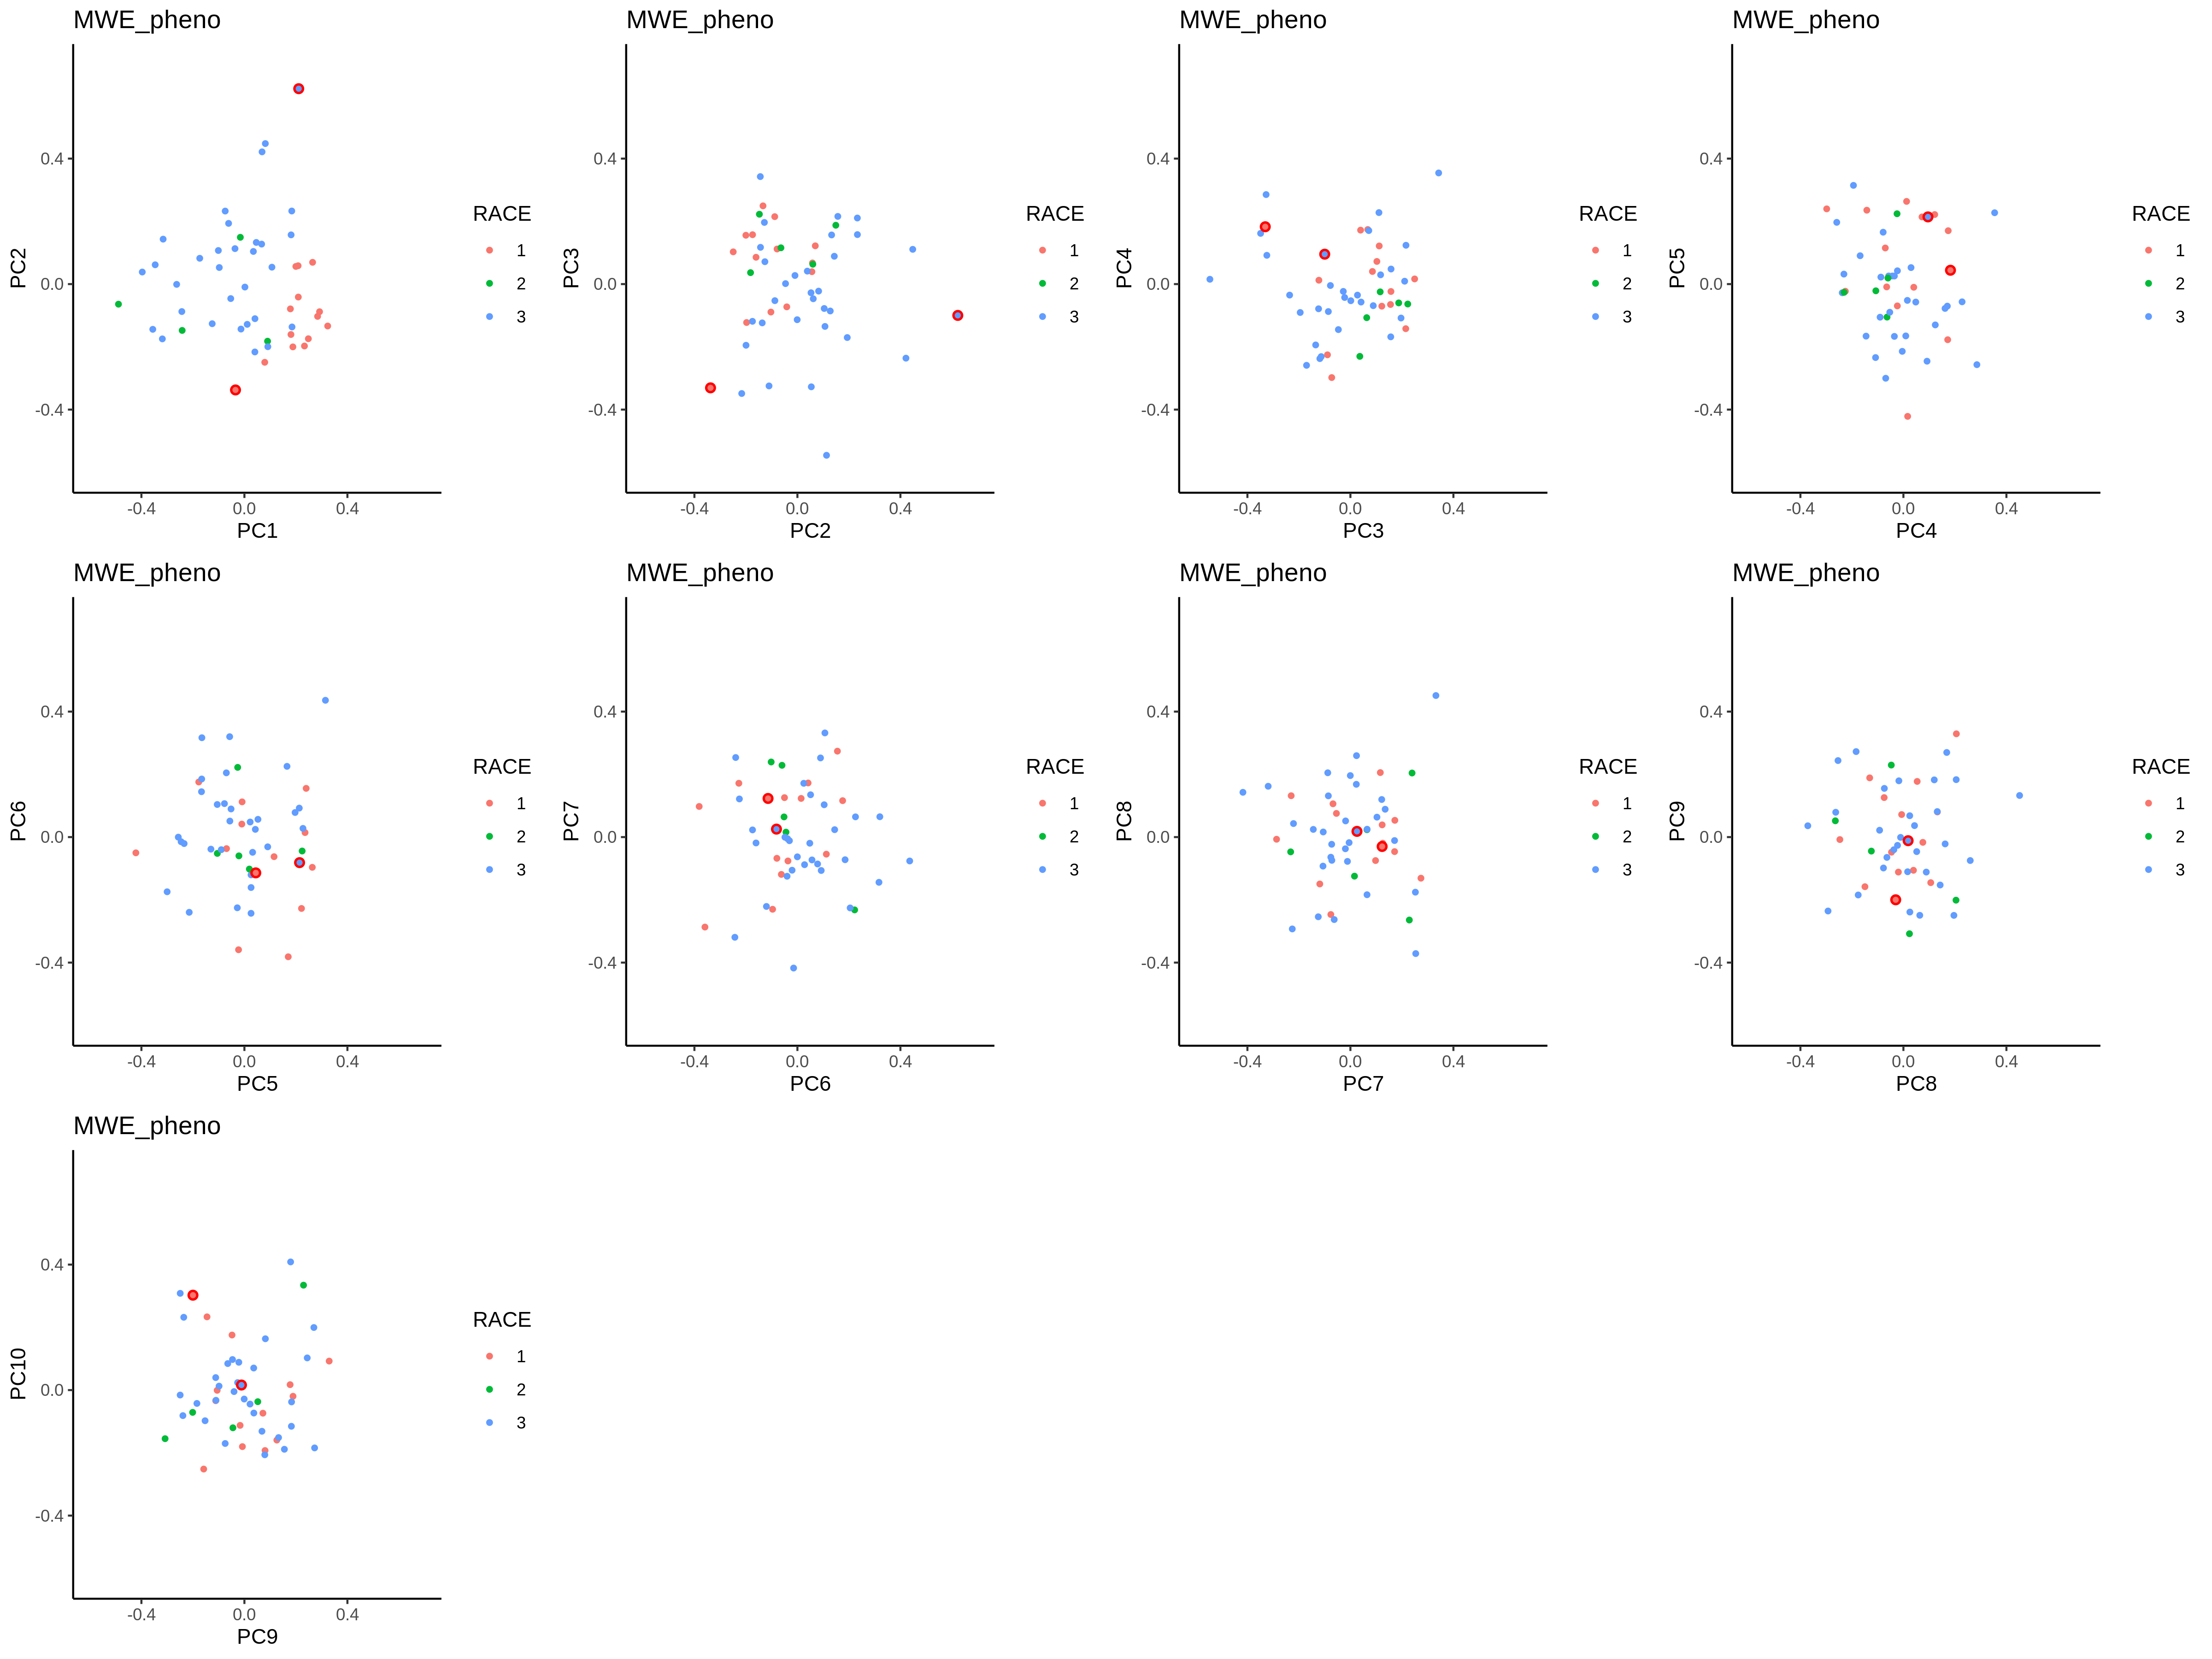

In [16]:
%preview 20210429/MWE_pheno.20210429.pca.projected.pc.png -n

Step 6: Split pheno data by population and extract genotype.Estimate kingship within each population(similar to step 1)

In [ ]:
pheno = read.table("MWE_AD/MWE_pheno.txt", header = TRUE)
for (i in 1:3){
 race = subset(pheno, RACE == i)
 race_id = race[, 1:2]
 write.table(race, paste0("MWE_AD/pheno/MWE_AD_race",i, ".txt"), quote = FALSE, sep = '\t', col.names = TRUE, row.names = FALSE)
 write.table(race_id, paste0("MWE_AD/pheno/ID.", "race", i), quote = FALSE, sep = '\t', col.names = FALSE, row.names = FALSE)
}

In [ ]:
for i in race1 race2 race3; do
sos run bioworkflows/GWAS/GWAS_QC.ipynb qc:1 \
  --container_lmm 'statisticalgenetics/lmm:1.9' \
  --genoFile MWE_AD/rename_chr22.bed \
  --keep-samples MWE_AD/pheno/ID.$i \
  --maf-filter 0 --geno-filter 0 --mind-filter 0.1 --hwe-filter 0\
  --name $i \
  --cwd MWE_AD/20210429 
sos run bioworkflows/GWAS/GWAS_QC.ipynb king \
  --cwd MWE_AD/20210429 \
  --container_lmm  'statisticalgenetics/lmm:1.9' \
  --genoFile MWE_AD/20210429/cache/rename_chr22.$i.filtered.bed \
  --kinship 0.13 
done

Step 7: For each population perform QC. set k = 2 as the sample size for races are small. similar to step 2 and step 3

In [ ]:
for i in race1 race2 race3; do
# unrelated individuals
sos run bioworkflows/GWAS/GWAS_QC.ipynb qc \
    --container_lmm 'statisticalgenetics/lmm:1.9' \
    --cwd MWE_AD/20210429 \
    --genoFile MWE_AD/20210429/cache/rename_chr22.$i.filtered.bed \
    --remove_samples MWE_AD/20210429/rename_chr22.$i.filtered.20210429.related_id \
    --maf_filter 0.5 \
    --geno_filter 0.2 \
    --mind_filter 0.1 \
    --hwe_filter 0.0 \
    --name unrelated \
    --cwd MWE_AD/20210429 \
    --window 50 \
    --shift 10 \
    --r2 0.5  
# related individuals same set of variants
sos run bioworkflows/GWAS/GWAS_QC.ipynb qc:1 \
    --cwd MWE_AD/20210429 \
    --genoFile MWE_AD/20210429/cache/rename_chr22.$i.filtered.bed \
    --keep_samples MWE_AD/20210429/rename_chr22.$i.filtered.20210429.related_id \
    --keep-variants MWE_AD/20210429/cache/rename_chr22.$i.filtered.unrelated.filtered.prune.in \
    --maf-filter 0 --geno-filter 0 --mind-filter 0.1 --hwe-filter 0 \
    --name related \
    --container_lmm 'statisticalgenetics/lmm:1.9' 
done

Step 8: For each population do PCA in unrelated individuals. Similar to step 4.

In [ ]:
for i in race1 race2 race3; do
sos run bioworkflows/GWAS/PCA.ipynb flashpca -s force \
  --container_lmm 'statisticalgenetics/lmm:1.9' \
  --cwd MWE_AD/20210429 \
  --genoFile MWE_AD/20210429/cache/rename_chr22.$i.filtered.unrelated.filtered.prune.bed \
  --phenoFile MWE_AD/pheno/MWE_AD_$i.txt \
  --label_col RACE \
  --pop_col RACE \
  --k 2
done

Step 9: For each population projection of related individuals and outlier detection. Similar to step 5

In [ ]:
for i in race1 race3; do
sos run bioworkflows/GWAS/PCA.ipynb project_samples \
  --container_lmm 'statisticalgenetics/lmm:1.9' \
  --cwd MWE_AD/20210429 \
  --genoFile MWE_AD/20210429/cache/rename_chr22.$i.filtered.related.filtered.extracted.bed \
  --phenoFile MWE_AD/pheno/MWE_AD_$i.txt\
  --label_col RACE \
  --pop_col RACE \
  --pca_model MWE_AD/20210429/MWE_AD_$i.20210429.pca.rds \
  --k 2 \
  --maha_k 2 \
  --prob 0.8 --pval 0.05
sos run bioworkflows/GWAS/PCA.ipynb plot_pca \
  --container_lmm 'statisticalgenetics/lmm:1.9' \
  --cwd MWE_AD/20210429 \
  --genoFile MWE_AD/20210429/cache/rename_chr22.$i.filtered.related.filtered.extracted.bed \
  --phenoFile MWE_AD/race1/MWE_AD_$i.txt \
  --label_col RACE \
  --pop_col RACE \
  --outlier_file MWE_AD/20210429/MWE_AD_$i.20210429.pca.projected.outliers \
  --plot_data MWE_AD/20210429/MWE_AD_$i.20210429.pca.rds \
  --k 2
done

> ../../MWE_AD/20210429/MWE_AD_race1.20210429.pca.pc.png (43.2 KiB):

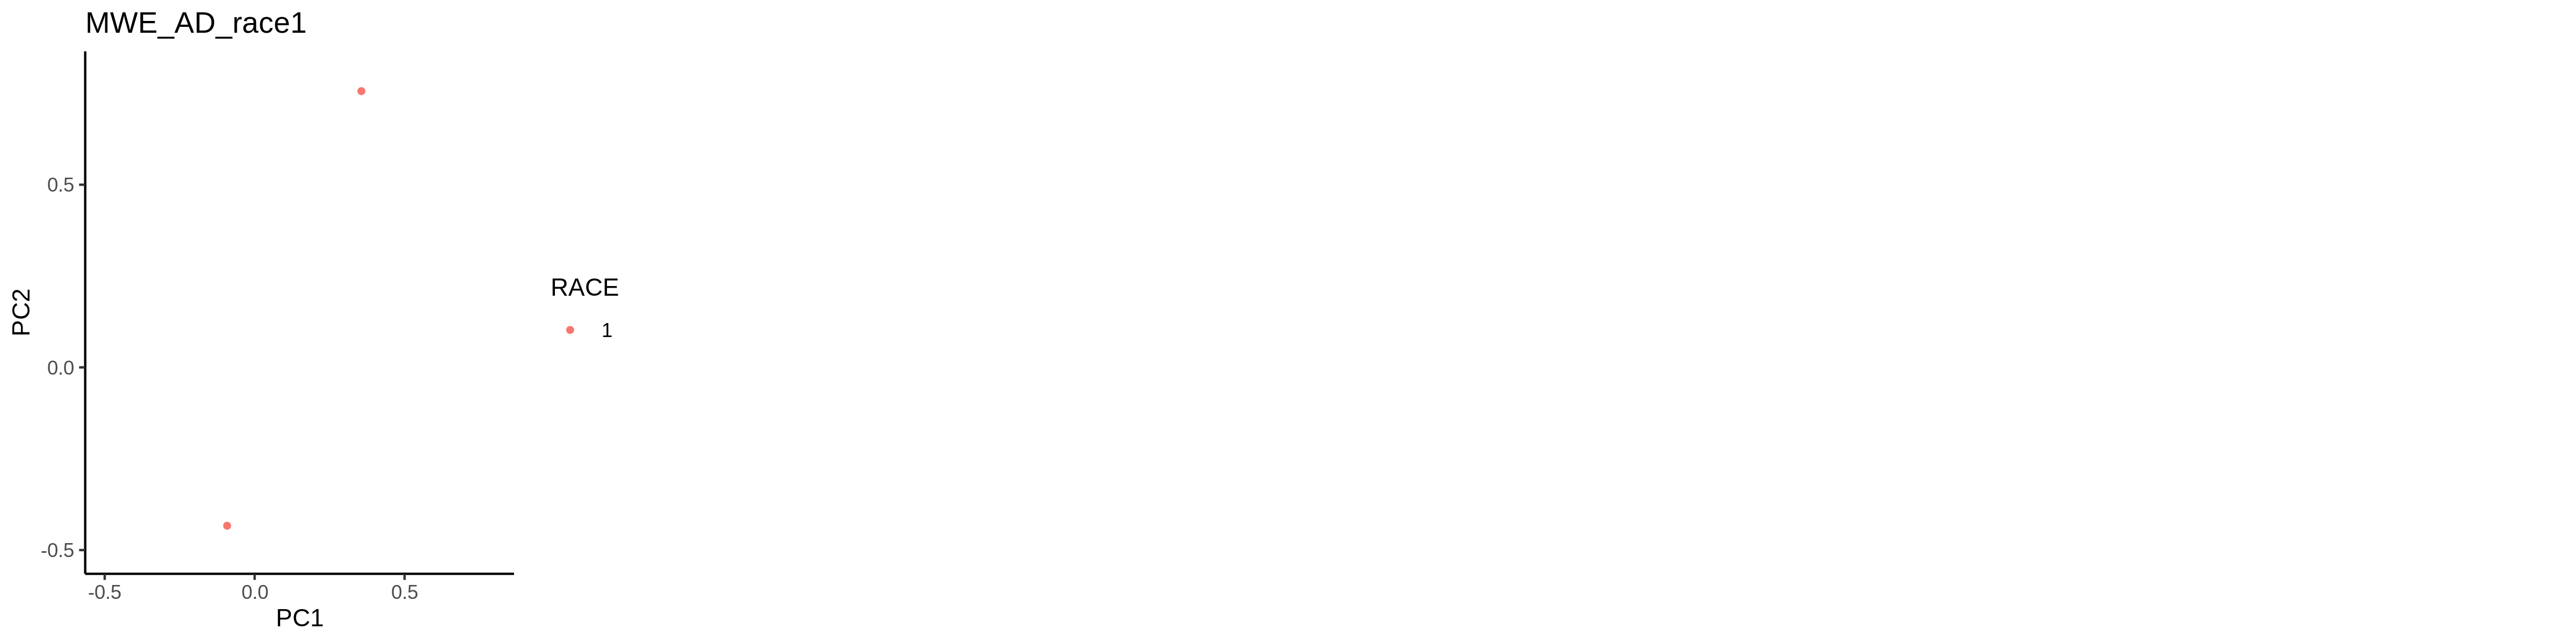

In [24]:
%preview ../../MWE_AD/20210429/MWE_AD_race1.20210429.pca.pc.png -n

> ../../MWE_AD/20210429/MWE_AD_race3.20210429.pca.pc.png (60.4 KiB):

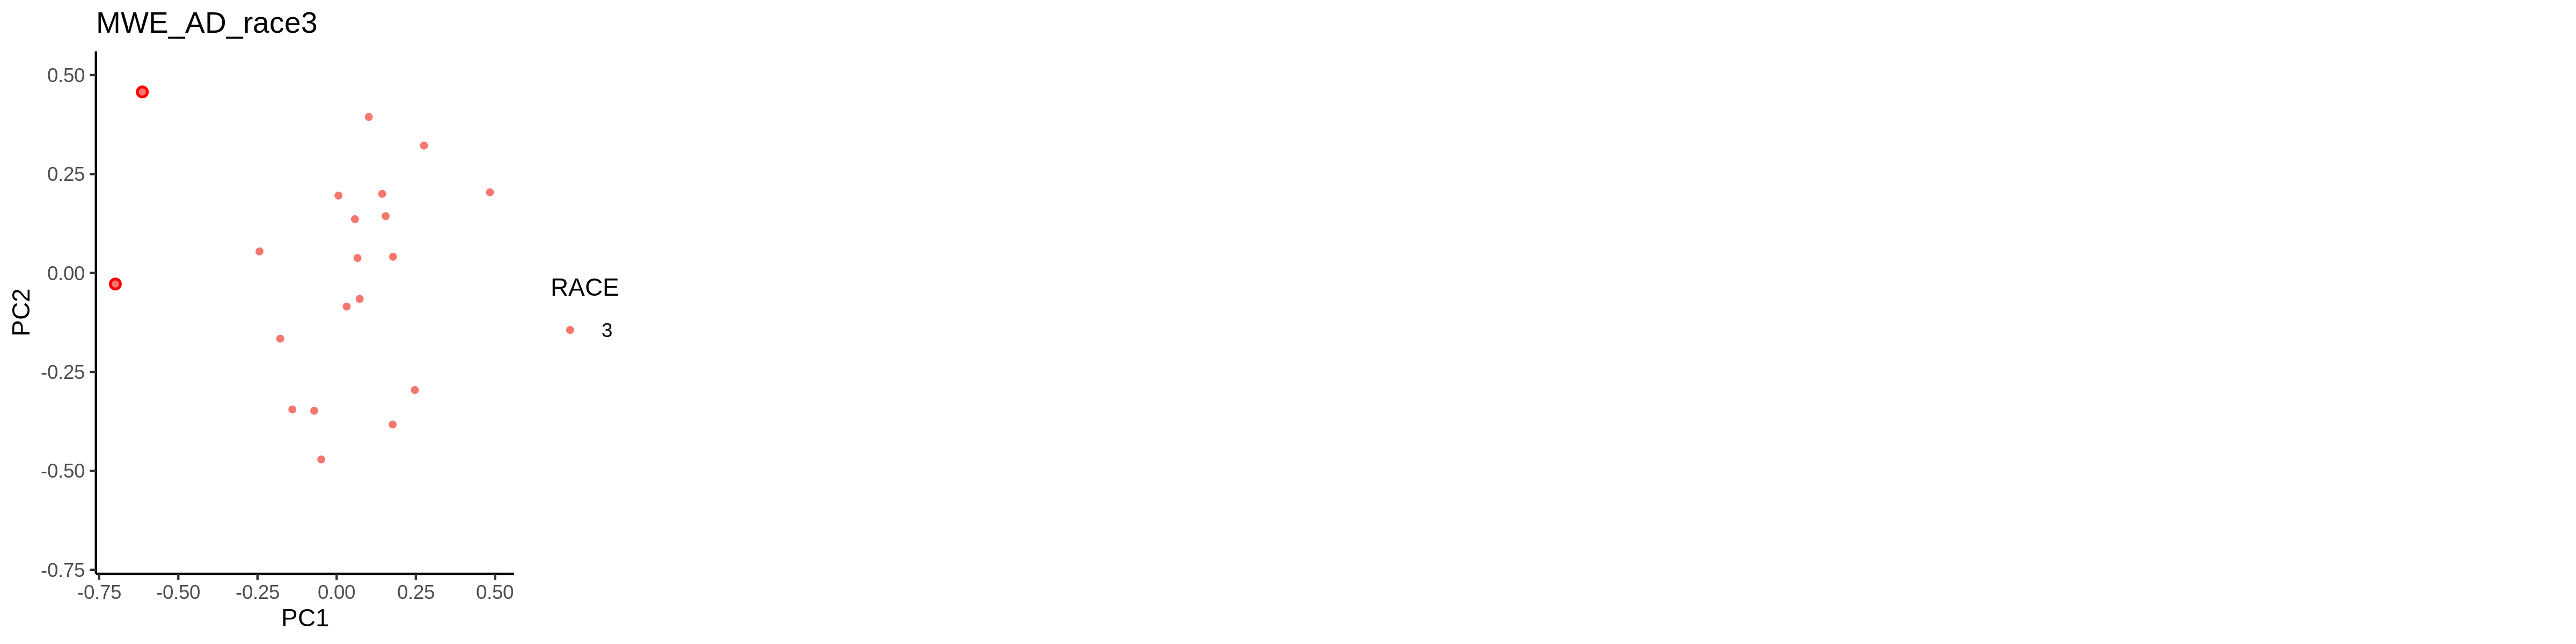

In [25]:
%preview ../../MWE_AD/20210429/MWE_AD_race3.20210429.pca.pc.png -n

Step 10: For each population remove outliers and finalize genotype QC
#### Data extraction for common variants

Here we keep variants having MAF > 0.01.

In [ ]:
for i in race1 race3; do
# unrelated individuals
sos run bioworkflows/GWAS/GWAS_QC.ipynb qc:1 \
    --cwd MWE_AD/20210429 \
    --genoFile MWE_AD/20210429/cache/rename_chr22.$i.filtered.bed \
    --keep_samples MWE_AD/pheno/ID.$i \
    --remove-samples MWE_AD/20210429/MWE_AD_$i.20210429.pca.projected.outliers \
    --maf_filter 0.01 \
    --geno_filter 0.1 \
    --mind_filter 0.1 \
    --hwe_filter 5e-08 \
    --name unrelated_common \
    --container_lmm 'statisticalgenetics/lmm:1.9'
cut -f 2 MWE_AD/20210429/cache/rename_chr22.race3.filtered.unrelated_common.filtered.bim > variant_id_$i.txt
# related individuals same set of variants
sos run bioworkflows/GWAS/GWAS_QC.ipynb qc:1 \
    --cwd MWE_AD/20210429 \
    --genoFile MWE_AD/20210429/cache/rename_chr22.$i.filtered.related.filtered.extracted.bed \
    --keep_samples MWE_AD/pheno/ID.$i \
    --remove-samples MWE_AD/20210429/MWE_AD_$i.20210429.pca.projected.outliers \
    --keep-variants variant_id_$i.txt \
    --maf-filter 0 --geno-filter 0 --mind-filter 0.1 --hwe-filter 0 \
    --name related_common \
    --container_lmm 'statisticalgenetics/lmm:1.9'
done

In [ ]:
# merge two data-sets
bash: container='statisticalgenetics/lmm:1.9'
for i in race1 race3; do
    plink --bfile MWE_AD/20210429/cache/rename_chr22.$i.filtered.related.filtered.extracted.related_common.filtered.extracted \
         --bmerge MWE_AD/20210429/cache/rename_chr22.$i.filtered.unrelated_common.filtered.bed \
                  MWE_AD/20210429/cache/rename_chr22.$i.filtered.unrelated_common.filtered.bim \
                  MWE_AD/20210429/cache/rename_chr22.$i.filtered.unrelated_common.filtered.fam \
        --make-bed --out MWE_AD/20210429/merged_plink_common.$i
done

#### Data extraction for rare variants
Here we keep variants having MAF <= 0.05.

In [ ]:
for i in race1 race3; do
# unrelated individuals
sos run bioworkflows/GWAS/GWAS_QC.ipynb qc:1 \
    --cwd MWE_AD/20210429 \
    --genoFile MWE_AD/20210429/cache/rename_chr22.$i.filtered.bed \
    --keep_samples MWE_AD/pheno/ID.$i \
    --remove-samples MWE_AD/20210429/MWE_AD_$i.20210429.pca.projected.outliers \
    --maf_filter 0.0 \
    --maf_max_filter 0.05 \
    --geno_filter 0.1 \
    --mind_filter 0.1 \
    --hwe_filter 5e-08 \
    --name unrelated_rare \
    --container_lmm 'statisticalgenetics/lmm:1.9'
cut -f 2 MWE_AD/20210429/cache/rename_chr22.race3.filtered.unrelated_common.filtered.bim > variant_id_$i.txt
# related individuals same set of variants
sos run bioworkflows/GWAS/GWAS_QC.ipynb qc:1 \
    --cwd MWE_AD/20210429 \
    --genoFile MWE_AD/20210429/cache/rename_chr22.$i.filtered.related.filtered.extracted.bed \
    --keep_samples MWE_AD/pheno/ID.$i \
    --remove-samples MWE_AD/20210429/MWE_AD_$i.20210429.pca.projected.outliers \
    --keep-variants variant_id_$i.txt \
    --maf-filter 0 --geno-filter 0 --mind-filter 0.1 --hwe-filter 0 \
    --name related_rare \
    --container_lmm 'statisticalgenetics/lmm:1.9'
done

In [ ]:
# merge two data-sets
bash: container='statisticalgenetics/lmm:1.9'
for i in race1 race3; do
    plink --bfile MWE_AD/20210429/cache/rename_chr22.$i.filtered.related.filtered.extracted.related_rare.filtered.extracted \
         --bmerge MWE_AD/20210429/cache/rename_chr22.$i.filtered.unrelated_rare.filtered.bed \
                  MWE_AD/20210429/cache/rename_chr22.$i.filtered.unrelated_rare.filtered.bim \
                  MWE_AD/20210429/cache/rename_chr22.$i.filtered.unrelated_rare.filtered.fam \
        --make-bed --out MWE_AD/20210429/merged_plink_rare.$i
done

## Command interface

In [1]:
sos run PCA.ipynb -h

usage: sos run PCA.ipynb [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  flashpca
  project_samples
  plot_pca
  detect_outliers

Global Workflow Options:
  --cwd VAL (as path, required)
                        the output directory for generated files
  --name  f"{cwd:b}"

                        A string to identify your analysis run
  --genoFile VAL (as path, required)
                        Plink binary file
  --phenoFile VAL (as path, required)
                        The phenotypic file
  --pop-col ''
                        Name of the population column in the phenoFile
  --pops  (as list)
  --label-col VAL (as str, required)
                        Name of the color label colu

In [1]:
[global]
# the output directory for generated files
parameter: cwd = path
# A string to identify your analysis run
parameter: name = ""
# Name of the population column in the phenoFile
parameter: pop_col = ""
parameter: pops = []
# Name of the color label column in the phenoFile; can be the same as population column
parameter: label_col = ""
# Number of Principal Components to output. Default is 10
parameter: k = 10
# Number of Principal Components based on which outliers should be evaluated. Default is 5 but this should be based on examine the scree plot
parameter: maha_k = 5
# Homogeneity of populations. Set to --homogeneous when true and --no-homogeneous when false
parameter: homogeneous = False
# Software container option
parameter: container = ""
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Wall clock time expected
parameter: walltime = "5h"
# Memory expected
parameter: mem = "16G"
# Number of threads
parameter: numThreads = 10
suffix = '_'.join(pops)
cwd = f"{cwd:a}"
if not pop_col:
    homogeneous = True
if not container:
    container = None

## PCA analysis

In [ ]:
# Run PCA analysis using flashpca 
[flashpca_1]
# Plink binary file
parameter: genoFile = path
# The phenotypic file
parameter: phenoFile = path(f'{genoFile}'.replace(".bed",".fam"))
# minimum population size to consider in the analysis
parameter: min_pop_size = 2
# How to standardize X before PCA
parameter: stand = "binom2"
## Input genoFile here is for unrelated samples
input: genoFile, phenoFile
output: f'{cwd}/{phenoFile:bn}{("."+name) if name else ""}.{(suffix+".") if suffix != "" else ""}pca.rds'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: container = container, expand = "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    # Load required libraries
    library(flashpcaR)
    library(dplyr)
    pops = c(${paths(pops):r,})
    f <- flashpca(${_input[0]:nr}, ndim=${k}, stand="${stand}", do_loadings=TRUE, check_geno=TRUE)
    rownames(f$loadings) <- read.table('${_input[0]:n}.bim',stringsAsFactors =F)[,2]
    # Use the projection file to generate pca plot
    pca <- as.data.frame(f$projection)
    pca <- tibble::rownames_to_column(pca, "ID")
    colnames(pca) <- c("ID",paste0("PC", 1:${k}))
    pca$IID <- sapply(strsplit(as.character(pca$ID),':'), "[", 1)
    # Read fam file with phenotypes
    if(stringr::str_detect(${_input[1]:r},".fam$")){
    pheno <- read.table(${_input[1]:r}, sep= "\t", header=F,stringsAsFactors =F)
    colnames(pheno) = c("FID", "IID", "MID", "PID", "SEX", "STATUS")
    } else {
    pheno <- read.table(${_input[1]:r}, sep="\t", header=T,stringsAsFactors =F)
    }
  
  
    if (length(pops)>0) pheno <- pheno %>%filter(super_pop %in% pops| pop %in% pops)
    pca <-merge(pheno, pca,by ="IID", all=FALSE) 
    # 
    if (${"TRUE" if pop_col else "FALSE"}) {
      # remove populations have less than ${min_pop_size} samples
        pop_filter<-pop[table(pca$pop)<${min_pop_size}] # pop to be removed
        if (length(pop_filter)>0) {
            warning(for (i in pop_filter){cat(i,';')},'these ', length(pop_filter)," population will be removed due to having less than ${min_pop_size} samples in data.")
            # remove
            pca<-pca%>% filter(${f'!{pop_col}%in%pop_filter' if pop_col else pop_col})
        }
    } else {
      pca$pop <- 1 
    }

    # Write the PC scores to a file
    write.table(pca,"${_output:n}.txt", sep="\t", quote=FALSE, row.names=FALSE, col.names=TRUE)
    dat = list(pca_model = f, pc_scores = pca, meta = "${_input[1]:bn} ${suffix}")
    # compute centroids before projecting back the samples
    # (calculate mean/median/cov per pop)
    if(${"FALSE" if homogeneous else "TRUE"}){
        pop_group <- split(dat$pc_scores[ ,c(paste0("PC", 1:${maha_k}))], list(Group = dat$pc_scores$${pop_col if pop_col else "pop"}))
        dat$pc_cov <- lapply(pop_group, function(x) cov(x))
        dat$pc_mean <- lapply(pop_group, function(x) sapply(x, mean))
        dat$pc_median <- lapply(pop_group, function(x) sapply(x, median))
    } else {
        dat$pc_cov <- cov(f$projection[,1:${maha_k}])
        dat$pc_mean <- apply(f$projection[,1:${maha_k}], 2, mean)
        dat$pc_median <- apply(f$projection[,1:${maha_k}], 2, median)
    }
  
    # save results
    saveRDS(dat, ${_output:r})

## Project related individuals back

In [ ]:
# Project back to PCA model additional samples
[project_samples_1]
# Plink binary file
parameter: genoFile = path
# The phenotypic file
parameter: phenoFile = path(f'{genoFile}'.replace(".bed",".fam"))
parameter: pca_model = f'{cwd}/{phenoFile:bn}{("."+name) if name else ""}.{(suffix+".") if suffix != "" else ""}pca.rds'
## Input genoFile here is for related samples
input: genoFile, phenoFile, pca_model
output: f'{cwd}/{phenoFile:bn}{("."+name) if name else ""}.pca.projected.rds'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    # Load required libraries
    library(dplyr)
    library(flashpcaR)
    # Read the PLINK binary files
    frel <- ${_input[0]:nr}
    # Read loadings, center and scale from previous PCA
    dat <- readRDS(${_input[2]:r})
    f <- dat$pca_model                           
    # Read the bim file to obtain reference alleles
    bim <- read.table('${_input[0]:n}.bim',stringsAsFactors =F)
    ref <- as.character(bim[,5])
    names(ref) <- bim[,2]
    overlapped_variants <- match(names(ref), rownames(f$loadings))
    # Project related samples
    fpro <- project(frel, loadings=f$loadings[overlapped_variants,], orig_mean=f$center[overlapped_variants], orig_sd=f$scale[overlapped_variants], ref_allele=ref)
    pca <- fpro$projection
    k = ${k}
    pca <- as.data.frame(fpro$projection)
    pca <- tibble::rownames_to_column(pca, "ID")
    colnames(pca) <- c("ID",paste0("PC", 1:k))
    pca$IID <- sapply(strsplit(as.character(pca$ID),':'), "[", 1)
    
    
    # Read fam file with phenotypes
    if(stringr::str_detect(${_input[1]:r},".fam$")){
    pheno <- read.table(${_input[1]:r}, sep= "\t", header=F,stringsAsFactors =F)
    colnames(pheno) = c("FID", "IID", "MID", "PID", "SEX", "STATUS")
    } else {
    pheno <- read.table(${_input[1]:r}, sep="\t", header=T,stringsAsFactors =F)
    }
    pca <-merge(pheno, pca,by ="IID", all=FALSE)
    dat$pc_scores = bind_rows(dat$pc_scores, pca)
    
    # Write the PC scores to a file
    write.table(dat$pc_scores,"${_output:n}.txt", sep="\t", quote=FALSE, row.names=FALSE, col.names=TRUE)
    # save results
    saveRDS(dat, ${_output:r})

## Plot PCA results


In [ ]:
# Plot PCA results. 
# Can be used independently as "plot_pca" or combined with other workflow as eg "flashpca+plot_pca"
[plot_pca]
parameter: outlier_file = path()
parameter: plot_data = path
parameter: min_axis = ""
parameter: max_axis = ""
input: plot_data
output: f'{cwd}/{_input:bn}.pc.png',
        f'{cwd}/{_input:bn}.scree.png'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = 1, tags = f'{step_name}_{_output[0]:bn}'
R: container = container,volumes = [f"{outlier_file:ad}:{outlier_file:ad}"], expand = "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'   
    library(dplyr)
    library(ggplot2)
    library(gridExtra)
    library(matrixStats)
    pops = c(${paths(pops):r,})
    dat = readRDS(${_input:r})
    f = dat$pca_model
    pca_final<-dat$pc_scores
    
    if (length(pops)>1) pca_final <- pca_final %>% filter(super_pop %in% pops| pop %in% pops) %>%
        mutate(${label_col if label_col else "pop"}=as.character(${label_col if label_col else  "pop"}))
    k = ${k}
    # manually set colors for PCA plotting, to avoid similar colors in one plot:
    # generated by https://mokole.com/palette.html
    set.seed(999)
    colors_40 = sample(c("#a9a9a9", "#2f4f4f", "#556b2f", "#a0522d", "#7f0000", "#006400", "#808000", "#483d8b", "#3cb371", "#bdb76b", "#4682b4", "#9acd32", 
                          "#20b2aa", "#00008b", "#32cd32", "#daa520", "#7f007f", "#b03060", "#ff0000", "#ff8c00", "#ffff00", "#0000cd", "#00ff00", "#9400d3", 
                          "#00fa9a", "#00ffff", "#00bfff", "#f4a460", "#f08080", "#adff2f", "#ff6347", "#ff00ff", "#1e90ff", "#dda0dd", "#7b68ee", "#afeeee", 
                          "#ee82ee", "#ff69b4", "#ffe4c4", "#ffc0cb"))
    colors_20 = sample(c("#2f4f4f", "#2e8b57", "#8b0000", "#808000", "#00008b", "#ff0000", "#ff8c00", "#00ff00", "#4169e1", "#00ffff", "#00bfff", "#0000ff", 
                          "#da70d6", "#d8bfd8", "#ff00ff", "#eee8aa", "#ffff54", "#ff1493", "#ffa07a", "#98fb98"))

    # assign colors to each ethnicity:
    num_col=length(unique(pca_final$${label_col if label_col else "pop"}))
    if (num_col <= 20) {
       color_list <- colors_20[1:num_col]
    } else {
       color_list <- colors_40[1:num_col]
    }

    ###
    # Make the plots
    ###
    # Get the min and max values for x and y-axes
    if (${"TRUE" if len(min_axis) == 0 or len(max_axis) == 0 else "FALSE"}) {
        min_axis <- round(colMins(as.matrix(f$projection[sapply(f$projection, is.numeric)])),1)
        max_axis <- round(colMaxs(as.matrix(f$projection[sapply(f$projection, is.numeric)])),1)  
    } else {
        min_axis <- as.double(${min_axis})
        max_axis <- as.double(${max_axis})
    }
    if (${"TRUE" if outlier_file.is_file() else "FALSE"}) {
        outliers <- read.table(${outlier_file:r}, col.names=c("FID", "IID"),stringsAsFactors =F)
        plot_pcs = function(pca_final, x, y, title="") {
            ggplot(pca_final, aes_string(x=x, y=y)) + geom_point(${f'aes(color={label_col})' if label_col else ""}) + 
              # add circles for these ouliters:
              geom_point(data=filter(pca_final, IID %in% outliers$IID, FID %in% outliers$FID), shape = 21, size=1.5, color='red', stroke = 0.9) +
              # add outliers dots:
              geom_point(data=filter(pca_final, IID %in% outliers$IID, FID %in% outliers$FID), shape = 16, size=1${f',aes(color={label_col})' if label_col else ""} ) + 
              labs(title=title,x=x, y=y) +
              scale_y_continuous(limits=c(min_axis, max_axis)) +
              scale_x_continuous(limits=c(min_axis, max_axis)) +
              scale_color_manual(values=color_list) +
              theme_classic()
        }} else {
        plot_pcs = function(pca_final, x, y, title="") {
          ggplot(pca_final, aes_string(x=x, y=y)) + geom_point(${f'aes(color={label_col})' if label_col else ""}) + 
              labs(title=title,x=x, y=y) +
              scale_y_continuous(limits=c(min_axis, max_axis)) +
              scale_x_continuous(limits=c(min_axis, max_axis)) +
              scale_color_manual(values=color_list) +
              theme_classic()
        }}
    unit = 4
    n_col = min(4, k)
    n_row = ceiling(k / n_col)
    plots = lapply(1:(k-1), function(i) plot_pcs(pca_final, paste0("PC",i), paste0("PC",i+1), dat$meta))
    png('${_output[0]}', width = unit * n_col, height = unit * n_row, unit='in', res=300)
    do.call(gridExtra::grid.arrange, c(plots, list(ncol = n_col, nrow = n_row)))
    dev.off()
    # Create scree plot
    PVE <- f$values
    PVE <- round(PVE/sum(PVE), 2)
    PVEplot <- qplot(c(1:length(PVE)), PVE) + geom_line() + xlab("Principal Component") + ylab("PVE") + ggtitle("Scree Plot") + ylim(0, 1) +scale_x_discrete(limits=factor(1:length(PVE)))
    PVE_cum <- cumsum(PVE)/sum(PVE)
    cumPVEplot <- qplot(c(1:length(PVE)), cumsum(PVE)) + geom_line() + xlab("Principal Component") + ylab("PVE") + ggtitle("Cumulative PVE Plot") + ylim(0, 1) + scale_x_discrete(limits=factor(1:length(PVE)))
    png('${_output[1]}', width = 8, height = 4, unit='in', res=300)
    grid.arrange(PVEplot, cumPVEplot, nrow = 1)
    dev.off()

## Detect outliers

In [ ]:
# Calculate Mahalanobis distance per population and report outliers
[detect_outliers]
# Set the probability to remove outliers eg 0.95 or 0.997
parameter: prob = 0.997
# Mahalanobis distance p-value cutoff
parameter: pval = 0.05
# Robust Mahalanobis to outliers
parameter: robust = True
parameter: pca_result = path
input: pca_result
output: distance=f'{_input:n}.mahalanobis.rds',
        identified_outliers=f'{_input:n}.outliers',
        analysis_summary=f'{_input:n}.analysis_summary.md',
        qqplot_mahalanobis=f'{_input:n}.mahalanobis_qq.png',
        hist_mahalanobis=f'{_input:n}.mahalanobis_hist.png'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = 1, tags = f'{step_name}_{_output[0]:bn}'
bash: container = container, expand = "${ }"
    echo '''---
    theme: base-theme
    style: |
      img {
        height: 80%;
        display: block;
        margin-left: auto;
        margin-right: auto;
      }
    ---    
    ''' > ${_output[2]}
    
R: container = container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    # Load required libraries
    library(dplyr)
    library(ggplot2)
    library(gridExtra)
  
    # invert a known covariance matrix but allow them to be numerically singular matrix (still assuming full rank)
    robust_inv = function(s) {
        #tryCatch(solve(s), error=function(cond) solve(Matrix::nearPD(s)$mat))
        tryCatch(solve(s), error=function(cond) MASS::ginv(s))
    }

    # Calculate mahalanobis distance  
    calc_mahalanobis_dist = function(x, m, s, name = '', prob=${prob}) {
        pc <- x %>%
          select("IID","FID", "${pop_col if pop_col else "pop"}", starts_with("PC"))
        mu_pc <- pc[,4:(4 + length(m) - 1)]
        pc$mahal = mahalanobis(mu_pc, m, robust_inv(s), inverted=TRUE)
        pc$p <- pchisq(pc$mahal, df=nrow(s), lower.tail=FALSE)
        manh_dis_sq_cutoff = quantile(pc$mahal, probs=prob)
        # Obtain outliers
        outliers = pc[(pc$mahal > manh_dis_sq_cutoff & pc$p < ${pval}),]
        d_summary = paste0(capture.output(summary(pc$mahal)), collapse = '\n')
        msg = paste('#', name, "result summary\n## Mahalanobis distance summary:\n```\n", d_summary, "\n```\n", 
            paste("The cut-off for outlier removal is set to:", manh_dis_sq_cutoff, "and the number of individuals to remove is:", nrow(outliers),"\n"),
            paste("The new sample size after outlier removal is:",nrow(pc) - nrow(outliers),"\n"))
        #
        outliers <- outliers %>%
        select(FID,IID)
      list(pc=pc, manh_dis_sq_cutoff=manh_dis_sq_cutoff, msg=msg, outliers=outliers)
    }

    dat = readRDS(${_input:r})
    if (is.list(dat$pc_mean)) {
      pops = names(dat$pc_mean)
      pop_group = split(dat$pc_scores, f = dat$pc_scores$${pop_col if pop_col else "pop"})
      res = lapply(pops, function(p) calc_mahalanobis_dist(pop_group[[p]], dat$${"pc_mean" if not robust else "pc_median"}[[p]], dat$pc_cov[[p]], name = paste(dat$meta, p)))
      names(res) = pops
      res = list(
          msg = do.call(paste, c(lapply(pops, function(p) res[[p]]$msg), sep = "\n")),
          manh_dis_sq_cutoff = cbind(pops, sapply(pops, function(p) res[[p]]$manh_dis_sq_cutoff)),
          outliers = do.call(rbind, c(lapply(pops, function(p) res[[p]]$outliers))),
          pc = do.call(rbind, c(lapply(pops, function(p) res[[p]]$pc)))
          )
    } else {
      res = calc_mahalanobis_dist(dat$pc_scores, dat$${"pc_mean" if not robust else "pc_median"}, dat$pc_cov, name = dat$meta)
    }
      
    write(res$msg, ${_output[2]:r})   
    # Plot mahalanobis
    k = ${k}
    png('${_output[3]}', width = 4, height = 4, unit='in', res=300)
    qqplot(qchisq(ppoints(100), df=k), res$pc$mahal, main = expression("Mahalanobis" * ~D^2 * " vs. quantiles of" * ~ chi[k]^2), xlab = expression(chi[2]^2 * ", probability points = 100"), ylab = expression(D^2), pch=16)
    abline(0,1,col='red')
    dev.off() 
    png('${_output[4]}', width = 4, height = 4, unit='in', res=300)
    ggplot(res$pc, aes(x=mahal)) + geom_histogram(aes(y = ..count..), binwidth = 0.5, colour = "#1F3552", fill = "#4271AE") + scale_x_continuous(name = "Mahalanobis distance") + theme_classic()
    dev.off()
  
    # Save results and outliers
    saveRDS(res,${_output[0]:r})
    write.table(res$outliers, ${_output[1]:r}, sep="\t", quote=FALSE, row.names=FALSE, col.names=FALSE)

## Add plot and outlier detection to PCA steps

In [ ]:
[flashpca_2, project_samples_2]
# Set the probability to remove outliers eg 0.95 or 0.997
parameter: prob = 0.997
# Robust Mahalanobis to outliers
parameter: robust = True
output: distance=f'{_input:n}.mahalanobis.rds',
        identified_outliers=f'{_input:n}.outliers',
        analysis_summary=f'{_input:n}.analysis_summary.md',
        qqplot_mahalanobis=f'{_input:n}.mahalanobis_qq.png',
        hist_mahalanobis=f'{_input:n}.mahalanobis_hist.png'
sos_run("detect_outliers", pca_result=_input, prob=prob, robust=robust)

[flashpca_3, project_samples_3]
input: output_from(1), output_from(2)['identified_outliers']
outliers = [x.strip() for x in open(_input[1]).readlines() if x.strip()]
output: f"{cwd}/{_input[0]:bn}.pc.png",
        f"{cwd}/{_input[0]:bn}.scree.png"
sos_run("plot_pca", plot_data = _input[0], outlier_file = _input[1] if len(outliers) else path())